## **Práctica 1: MLLIB CON DATASET DE RETRASOS DE VUELOS**

### 1. Carga de datos

Importamos las librerías necesarias

In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import pandas as pd
import os, sys

# Ruta Andrés
os.environ['JAVA_HOME'] = 'C:\Program Files\Eclipse Adoptium\jdk-17.0.16.8-hotspot'
# Ruta Vila
# os.environ['JAVA_HOME'] = '/Library/Java/JavaVirtualMachines/jdk-17.jdk/Contents/Home'
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

# spark = SparkSession.builder.getOrCreate()

spark = SparkSession.builder \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.maxResultSize", "2g") \
    .getOrCreate()

Cargamos los datos con Pyspark y mostramos las primeras 5 filas

In [3]:
# Carga de datos con Pyspark

df = spark.read.csv('full_data_flightdelay.csv', header=True, inferSchema=True)
df.show(5)

+-----+-----------+---------+------------+--------------+--------------+------------------+---------------+--------------------+---------------------+---------------------+-----------------------------+------------------------+------------------------+-----------------------+--------------------+---------+--------------------+--------+---------+----------------+----+----+----+----+----+
|MONTH|DAY_OF_WEEK|DEP_DEL15|DEP_TIME_BLK|DISTANCE_GROUP|SEGMENT_NUMBER|CONCURRENT_FLIGHTS|NUMBER_OF_SEATS|        CARRIER_NAME|AIRPORT_FLIGHTS_MONTH|AIRLINE_FLIGHTS_MONTH|AIRLINE_AIRPORT_FLIGHTS_MONTH|AVG_MONTHLY_PASS_AIRPORT|AVG_MONTHLY_PASS_AIRLINE|FLT_ATTENDANTS_PER_PASS|GROUND_SERV_PER_PASS|PLANE_AGE|   DEPARTING_AIRPORT|LATITUDE|LONGITUDE|PREVIOUS_AIRPORT|PRCP|SNOW|SNWD|TMAX|AWND|
+-----+-----------+---------+------------+--------------+--------------+------------------+---------------+--------------------+---------------------+---------------------+-----------------------------+------------------

### 2. Análisis exploratorio de datos (EDA)

Mostramos el tipo de dato de cada columna

In [4]:
# Mostramos los tipos de datos de cada columna (schema)

df.printSchema()

root
 |-- MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- DEP_DEL15: integer (nullable = true)
 |-- DEP_TIME_BLK: string (nullable = true)
 |-- DISTANCE_GROUP: integer (nullable = true)
 |-- SEGMENT_NUMBER: integer (nullable = true)
 |-- CONCURRENT_FLIGHTS: integer (nullable = true)
 |-- NUMBER_OF_SEATS: integer (nullable = true)
 |-- CARRIER_NAME: string (nullable = true)
 |-- AIRPORT_FLIGHTS_MONTH: integer (nullable = true)
 |-- AIRLINE_FLIGHTS_MONTH: integer (nullable = true)
 |-- AIRLINE_AIRPORT_FLIGHTS_MONTH: integer (nullable = true)
 |-- AVG_MONTHLY_PASS_AIRPORT: integer (nullable = true)
 |-- AVG_MONTHLY_PASS_AIRLINE: integer (nullable = true)
 |-- FLT_ATTENDANTS_PER_PASS: double (nullable = true)
 |-- GROUND_SERV_PER_PASS: double (nullable = true)
 |-- PLANE_AGE: integer (nullable = true)
 |-- DEPARTING_AIRPORT: string (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- PREVIOUS_AIRPORT: stri

In [5]:
# Mostramos número de filas y columnas

print('Número de filas:', df.count())
print('Número de columnas:', len(df.columns))

Número de filas: 6489062
Número de columnas: 26


In [6]:
# Mostramos cuantos vuelos llegaron con retraso (DEP_DEL15 = 1) y cuantos no (DEP_DEL15 = 0)

df.groupBy('DEP_DEL15').count().show()

+---------+-------+
|DEP_DEL15|  count|
+---------+-------+
|        1|1227368|
|        0|5261694|
+---------+-------+



In [7]:
# Miramos si existen valores nulos en cada columna, sin importar el tipo de dato

from pyspark.sql.functions import col, sum

null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show()

+-----+-----------+---------+------------+--------------+--------------+------------------+---------------+------------+---------------------+---------------------+-----------------------------+------------------------+------------------------+-----------------------+--------------------+---------+-----------------+--------+---------+----------------+----+----+----+----+----+
|MONTH|DAY_OF_WEEK|DEP_DEL15|DEP_TIME_BLK|DISTANCE_GROUP|SEGMENT_NUMBER|CONCURRENT_FLIGHTS|NUMBER_OF_SEATS|CARRIER_NAME|AIRPORT_FLIGHTS_MONTH|AIRLINE_FLIGHTS_MONTH|AIRLINE_AIRPORT_FLIGHTS_MONTH|AVG_MONTHLY_PASS_AIRPORT|AVG_MONTHLY_PASS_AIRLINE|FLT_ATTENDANTS_PER_PASS|GROUND_SERV_PER_PASS|PLANE_AGE|DEPARTING_AIRPORT|LATITUDE|LONGITUDE|PREVIOUS_AIRPORT|PRCP|SNOW|SNWD|TMAX|AWND|
+-----+-----------+---------+------------+--------------+--------------+------------------+---------------+------------+---------------------+---------------------+-----------------------------+------------------------+-----------------------

**NOTA**: No hay nulos en ninguna de las columnas.

In [9]:
# Hacemos un Análisis Estadístico Descriptivo

df.summary().show()

+-------+------------------+------------------+-------------------+------------+------------------+------------------+------------------+------------------+--------------------+---------------------+---------------------+-----------------------------+------------------------+------------------------+-----------------------+--------------------+------------------+-----------------+-----------------+------------------+--------------------+-------------------+-------------------+-------------------+------------------+------------------+
|summary|             MONTH|       DAY_OF_WEEK|          DEP_DEL15|DEP_TIME_BLK|    DISTANCE_GROUP|    SEGMENT_NUMBER|CONCURRENT_FLIGHTS|   NUMBER_OF_SEATS|        CARRIER_NAME|AIRPORT_FLIGHTS_MONTH|AIRLINE_FLIGHTS_MONTH|AIRLINE_AIRPORT_FLIGHTS_MONTH|AVG_MONTHLY_PASS_AIRPORT|AVG_MONTHLY_PASS_AIRLINE|FLT_ATTENDANTS_PER_PASS|GROUND_SERV_PER_PASS|         PLANE_AGE|DEPARTING_AIRPORT|         LATITUDE|         LONGITUDE|    PREVIOUS_AIRPORT|               PRCP

In [8]:
# Contamos cuantos valores diferentes hay en cada columna categórica
categorical_columns = ["DEP_TIME_BLK", "CARRIER_NAME", "DEPARTING_AIRPORT", "PREVIOUS_AIRPORT"]

for column in categorical_columns:
    distinct_count = df.select(column).distinct().count()
    print(f"Columna '{column}' tiene {distinct_count} valores distintos.")

Columna 'DEP_TIME_BLK' tiene 19 valores distintos.
Columna 'CARRIER_NAME' tiene 17 valores distintos.
Columna 'DEPARTING_AIRPORT' tiene 96 valores distintos.
Columna 'PREVIOUS_AIRPORT' tiene 356 valores distintos.


In [ ]:
# Miramos la distribución de las variables categóricas

for column in categorical_columns:
    print(f"Distribución de la columna '{column}':")
    df.groupBy(column).count().orderBy('count', ascending=False).show(5)  # Mostramos los 10 más comunes

Distribución de la columna 'DEP_TIME_BLK':
+------------+------+
|DEP_TIME_BLK| count|
+------------+------+
|   0800-0859|452391|
|   0700-0759|436032|
|   0600-0659|430404|
|   1700-1759|408878|
|   1200-1259|398009|
+------------+------+
only showing top 5 rows
Distribución de la columna 'CARRIER_NAME':
+--------------------+-------+
|        CARRIER_NAME|  count|
+--------------------+-------+
|Southwest Airline...|1296329|
|Delta Air Lines Inc.| 938346|
|American Airlines...| 903640|
|United Air Lines ...| 601044|
|SkyWest Airlines ...| 584204|
+--------------------+-------+
only showing top 5 rows
Distribución de la columna 'DEPARTING_AIRPORT':
+--------------------+------+
|   DEPARTING_AIRPORT| count|
+--------------------+------+
|   Atlanta Municipal|392603|
|Chicago O'Hare In...|329045|
|Dallas Fort Worth...|296449|
|Stapleton Interna...|247175|
|   Douglas Municipal|231855|
+--------------------+------+
only showing top 5 rows
Distribución de la columna 'PREVIOUS_AIRPORT':


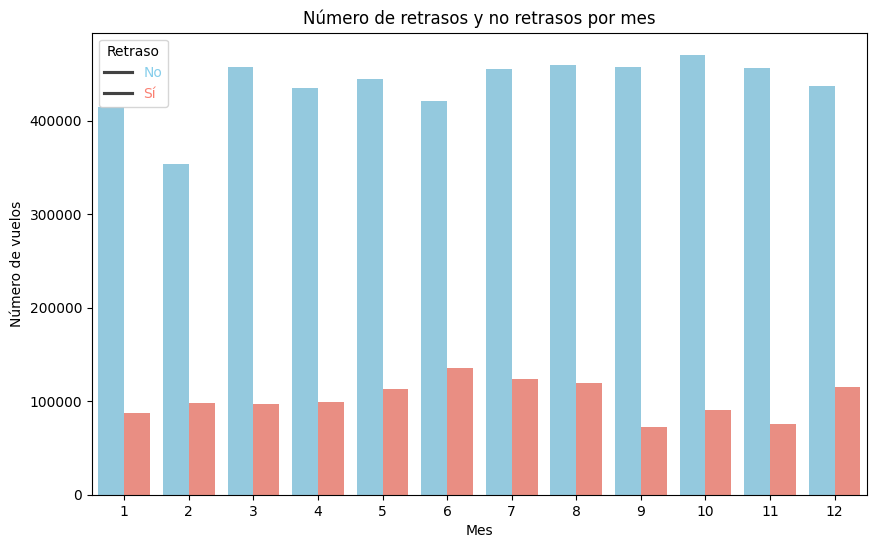

In [10]:
# Comparamos el número de retrasos y no retrasos por mes

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df_grouped = (df.groupBy("MONTH", "DEP_DEL15").count().orderBy("MONTH"))

df_pandas = df_grouped.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=df_pandas, x="MONTH", y="count", hue="DEP_DEL15", palette=["skyblue", "salmon"])
plt.title("Número de retrasos y no retrasos por mes")
plt.xlabel("Mes")
plt.ylabel("Número de vuelos")
plt.legend(title="Retraso", labels=["No", "Sí"], labelcolor=["skyblue", "salmon"])
plt.show()

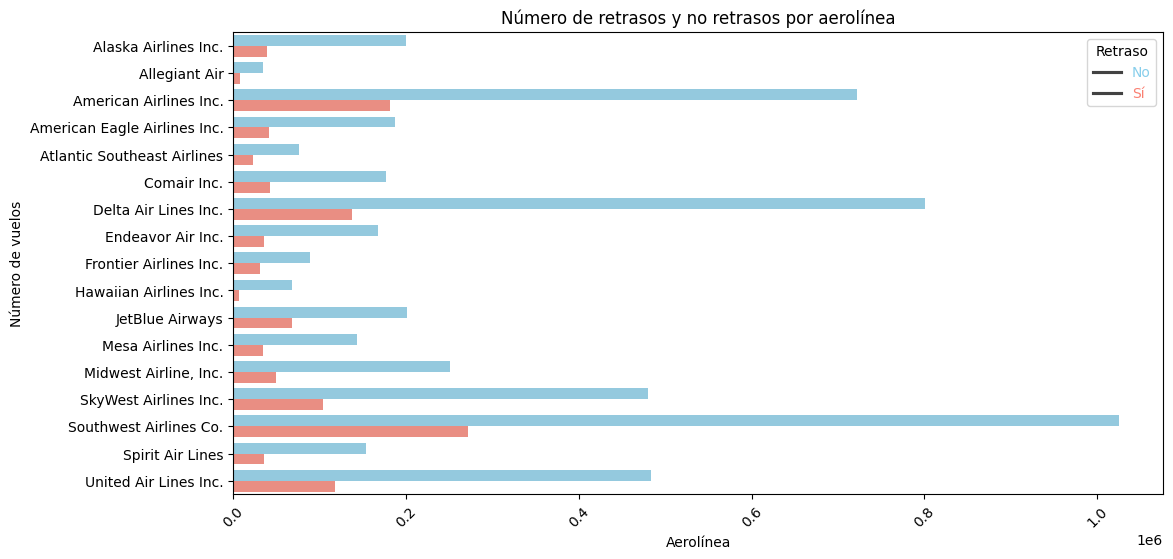

In [11]:
# Comparamos los vuelos con y sin retraso en cada aerolínea

df_grouped_airline = (df.groupBy("CARRIER_NAME", "DEP_DEL15").count().orderBy("CARRIER_NAME"))
df_pandas_airline = df_grouped_airline.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(data=df_pandas_airline, y="CARRIER_NAME", x="count", hue="DEP_DEL15", palette=["skyblue", "salmon"])
plt.title("Número de retrasos y no retrasos por aerolínea")
plt.xlabel("Aerolínea")
plt.ylabel("Número de vuelos")
plt.legend(title="Retraso", labels=["No", "Sí"], labelcolor=["skyblue", "salmon"])
plt.xticks(rotation=45)
plt.show()

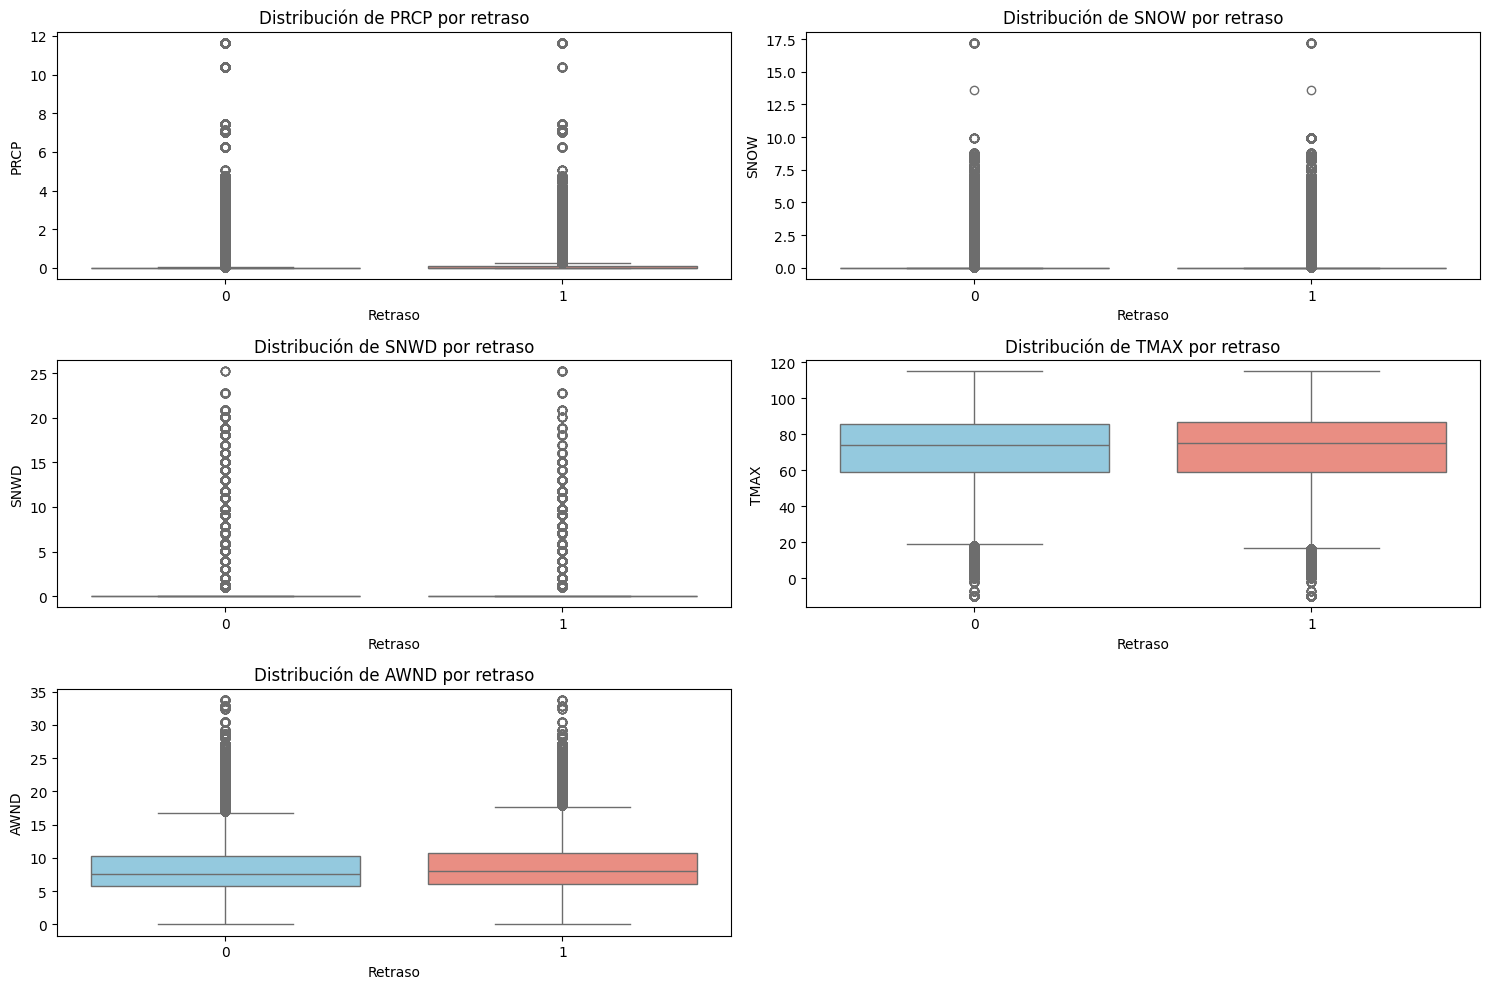

In [12]:
# Hacemos un análisis entre los retrasos y no con las variables relacionadas con la climatología (PRCP, SNOW, SNWD, TMAX, AWND)

df_weather = df.select("PRCP", "SNOW", "SNWD", "TMAX", "AWND", "DEP_DEL15")
df_weather_pandas = df_weather.toPandas()

plt.figure(figsize=(15, 10))
for i, column in enumerate(df_weather_pandas.columns[:-1], 1):
    plt.subplot(3, 2, i)
    sns.boxplot(data=df_weather_pandas, x="DEP_DEL15", y=column, palette=["skyblue", "salmon"], hue="DEP_DEL15", legend=False)
    plt.title(f"Distribución de {column} por retraso")
    plt.xlabel("Retraso")
    plt.ylabel(column)
plt.tight_layout()
plt.show()

El dataset está desbalanceado, ya que la mayoría de los vuelos no tienen retraso (considerando retraso > 15 minutos).

Hacemos undersampling para balancear las clases y reducir el tamaño del dataset.

In [ ]:
# Como hay más vuelos sin retraso que con retraso, el dataset está desbalanceado
# Para balancearlo, vamos a hacer un undersampling de los vuelos sin retraso

df_delay = df.filter(df.DEP_DEL15 == 1)
df_no_delay = df.filter(df.DEP_DEL15 == 0)
df_no_delay = df.filter(df.DEP_DEL15 == 0).sample(False, df_delay.count() / df_no_delay.count(), seed=42)
df_balanced = df_delay.union(df_no_delay)

print('Número de filas después del balanceo:', df_balanced.count())
print("Número de vuelos con y sin retraso después del balanceo:")
print("Con retraso:", df_balanced.filter(df_balanced.DEP_DEL15 == 1).count())
print("Sin retraso:", df_balanced.filter(df_balanced.DEP_DEL15 == 0).count())

Número de filas después del balanceo: 2455100
Número de vuelos con y sin retraso después del balanceo:
Con retraso: 1227368
Sin retraso: 1227732


In [ ]:
# Guardamos el dataset balanceado en un nuevo archivo CSV
df_balanced.coalesce(1).write.csv('balanced_flightdelay_data.csv', header=True, mode='overwrite')

In [2]:
df_balanced = spark.read.csv('balanced_data_flightdelay.csv', header=True, inferSchema=True)

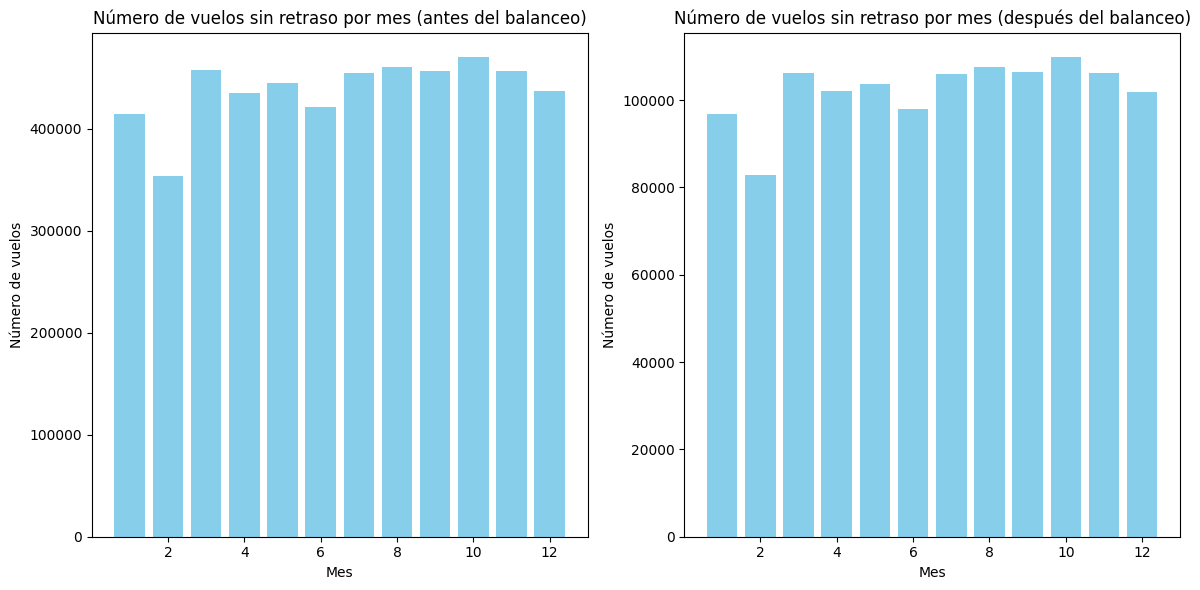

In [10]:
import matplotlib.pyplot as plt

# Lohacemos en un subplot para comparar mejor y con las menos lineas posibles
df_no_delay = df.filter(df.DEP_DEL15 == 0)
df_no_delay_grouped = df_no_delay.groupBy("MONTH").count().orderBy("MONTH")
df_no_delay_pandas = df_no_delay_grouped.toPandas()
df_no_delay_balanced = df_balanced.filter(df_balanced.DEP_DEL15 == 0)
df_no_delay_balanced_grouped = df_no_delay_balanced.groupBy("MONTH").count().orderBy("MONTH")
df_no_delay_balanced_pandas = df_no_delay_balanced_grouped.toPandas()
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(df_no_delay_pandas["MONTH"], df_no_delay_pandas["count"], color='skyblue')
plt.title("Número de vuelos sin retraso por mes (antes del balanceo)")
plt.xlabel("Mes")
plt.ylabel("Número de vuelos")
plt.subplot(1, 2, 2)
plt.bar(df_no_delay_balanced_pandas["MONTH"], df_no_delay_balanced_pandas["count"], color='skyblue')
plt.title("Número de vuelos sin retraso por mes (después del balanceo)")
plt.xlabel("Mes")
plt.ylabel("Número de vuelos")
plt.tight_layout()
plt.show()

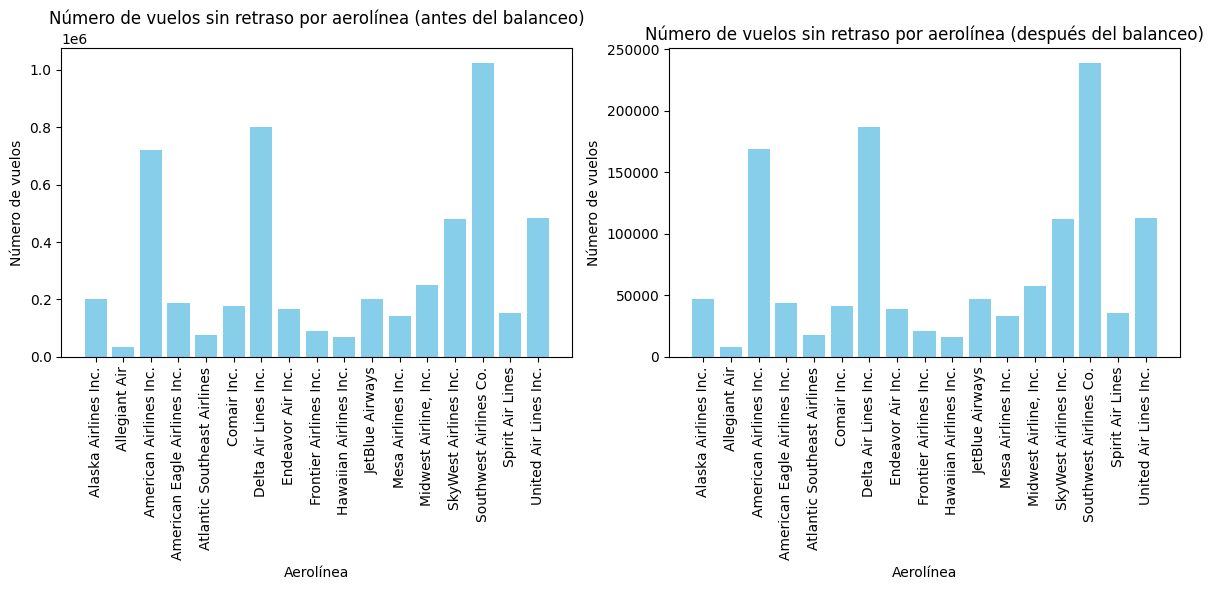

In [11]:
# Ahora por aerolínea
df_no_delay = df.filter(df.DEP_DEL15 == 0)
df_no_delay_grouped = df_no_delay.groupBy("CARRIER_NAME").count().orderBy("CARRIER_NAME")
df_no_delay_pandas = df_no_delay_grouped.toPandas()
df_no_delay_balanced = df_balanced.filter(df_balanced.DEP_DEL15 == 0)
df_no_delay_balanced_grouped = df_no_delay_balanced.groupBy("CARRIER_NAME").count().orderBy("CARRIER_NAME")
df_no_delay_balanced_pandas = df_no_delay_balanced_grouped.toPandas()
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(df_no_delay_pandas["CARRIER_NAME"], df_no_delay_pandas["count"], color='skyblue')
plt.title("Número de vuelos sin retraso por aerolínea (antes del balanceo)")
plt.xlabel("Aerolínea")
plt.ylabel("Número de vuelos")
plt.xticks(rotation=90)
plt.subplot(1, 2, 2)
plt.bar(df_no_delay_balanced_pandas["CARRIER_NAME"], df_no_delay_balanced_pandas["count"], color='skyblue')
plt.title("Número de vuelos sin retraso por aerolínea (después del balanceo)")
plt.xlabel("Aerolínea")
plt.ylabel("Número de vuelos")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 3. Preprocesado

Ahora ya cargamos directamente el nuevo dataset balanceado

In [2]:
# Cargamos el nuevo dataset balanceado
# df = df_balanced
df = spark.read.csv('balanced_data_flightdelay.csv', header=True, inferSchema=True)

Mapear las variables categóricas a numéricas usando StringIndexer


In [3]:
# Mapear las variables categóricas a numéricas usando StringIndexer
from pyspark.ml.feature import StringIndexer

# No utilizamos la variable "PREVIOUS_AIRPORT" porque tiene demasiados valores únicos

categorical_columns = ["DEP_TIME_BLK", "CARRIER_NAME", "DEPARTING_AIRPORT"]

numerical_columns = ["MONTH", "DAY_OF_WEEK", "DISTANCE_GROUP", "SEGMENT_NUMBER", "CONCURRENT_FLIGHTS", "NUMBER_OF_SEATS",
                     "AIRPORT_FLIGHTS_MONTH", "AIRLINE_FLIGHTS_MONTH", "AIRLINE_AIRPORT_FLIGHTS_MONTH", "AVG_MONTHLY_PASS_AIRPORT",
                     "AVG_MONTHLY_PASS_AIRLINE", "FLT_ATTENDANTS_PER_PASS", "GROUND_SERV_PER_PASS", "PLANE_AGE", "LATITUDE", "LONGITUDE", 
                     "PRCP", "SNOW", "SNWD", "TMAX", "AWND"]

indexers = StringIndexer(inputCols=categorical_columns, outputCols=[col+"_index" for col in categorical_columns])

In [4]:
# OneHotEncoder las variables categóricas

from pyspark.ml.feature import OneHotEncoder
encoder = OneHotEncoder(inputCols=indexers.getOutputCols(), outputCols=[x + "_ohe" for x in categorical_columns])

In [5]:
# Preparamos los datos para entrenar el modelo con todas las características

from pyspark.ml.feature import VectorAssembler
vecAssembler = VectorAssembler(inputCols=encoder.getOutputCols() + numerical_columns, outputCol="features")

### 4. Entrenamiento y evaluación de modelos

En un primer lugar vamos a entrenar varios modelos con todas las características

In [9]:
# Creamos un Pipeline con todas las etapas
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[indexers, encoder, vecAssembler])

# Dividimos los datos en entrenamiento y prueba
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

print(f'Tamaño del conjunto de entrenamiento: {train_data.count()}')
print(f'Tamaño del conjunto de prueba: {test_data.count()}')

# Ejecutamos el pipeline sobre el conjunto de entrenamiento
pipeline_model = pipeline.fit(train_data)
train_transformed = pipeline_model.transform(train_data)
train_transformed.select("features", "DEP_DEL15").show(5)

test_transformed = pipeline_model.transform(test_data)

25/10/17 17:35:35 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Tamaño del conjunto de entrenamiento: 1964488


Tamaño del conjunto de prueba: 490612


+--------------------+---------+
|            features|DEP_DEL15|
+--------------------+---------+
|(150,[17,22,85,12...|        1|
|(150,[17,30,64,12...|        1|
|(150,[17,20,111,1...|        1|
|(150,[17,22,74,12...|        1|
|(150,[17,19,41,12...|        1|
+--------------------+---------+
only showing top 5 rows



#### 4.1 Entrenamiento con todas las variables menos PREVIOUS_AIRPORT

In [ ]:
# Empezamos entrenando con un modelo de Regresión Logística
from pyspark.ml.classification import LogisticRegression

# Vamos a evaluar la accuracy, recall, precisión y F1-score
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Creamos el modelo de Regresión Logística sin cross-validation

lr = LogisticRegression(featuresCol='features', labelCol='DEP_DEL15')
lr_model = lr.fit(train_transformed)
predictions = lr_model.transform(test_transformed)

# Evaluamos el modelo
evaluator = MulticlassClassificationEvaluator(labelCol='DEP_DEL15', predictionCol='prediction')
accuracy_lr = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision_lr = evaluator.evaluate(predictions, {evaluator.metricName: "precisionByLabel"})
recall_lr = evaluator.evaluate(predictions, {evaluator.metricName: "recallByLabel"})
f1_score_lr = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
auc_roc_lr = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})

print(f'Accuracy del modelo de Regresión Logística: {accuracy_lr}')
print(f'Precisión del modelo de Regresión Logística: {precision_lr}')
print(f'Recall del modelo de Regresión Logística: {recall_lr}')
print(f'F1-score del modelo de Regresión Logística: {f1_score_lr}')

25/10/17 14:10:31 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/10/17 14:10:31 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


Accuracy del modelo de Regresión Logística: 0.6179893683807163
Precisión del modelo de Regresión Logística: 0.6286106364945042
Recall del modelo de Regresión Logística: 0.5726541817825277
F1-score del modelo de Regresión Logística: 0.6171975116402888


In [20]:
# Creamos un modelo SVM
from pyspark.ml.classification import LinearSVC

svm = LinearSVC(featuresCol='features', labelCol='DEP_DEL15')
svm_model = svm.fit(train_transformed)
predictions_svm = svm_model.transform(test_transformed)

# Evaluamos el modelo
evaluator = MulticlassClassificationEvaluator(labelCol='DEP_DEL15', predictionCol='prediction')
accuracy_svm = evaluator.evaluate(predictions_svm, {evaluator.metricName: "accuracy"})
precision_svm = evaluator.evaluate(predictions_svm, {evaluator.metricName: "precisionByLabel"})
recall_svm = evaluator.evaluate(predictions_svm, {evaluator.metricName: "recallByLabel"})
f1_score_svm = evaluator.evaluate(predictions_svm, {evaluator.metricName: "f1"})

print(f'Accuracy del modelo SVM: {accuracy_svm}')
print(f'Precisión del modelo SVM: {precision_svm}')
print(f'Recall del modelo SVM: {recall_svm}')
print(f'F1-score del modelo SVM: {f1_score_svm}')

Accuracy del modelo SVM: 0.5999037936291816
Precisión del modelo SVM: 0.6181199812894675
Recall del modelo SVM: 0.5182615942739485
F1-score del modelo SVM: 0.5972164545464509


In [21]:
# Ahora probamos con un modelo de Árbol de Decisión
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol='features', labelCol='DEP_DEL15')
dt_model = dt.fit(train_transformed)
dt_predictions = dt_model.transform(test_transformed)

# Evaluamos el modelo
dt_accuracy = evaluator.evaluate(dt_predictions, {evaluator.metricName: "accuracy"})
dt_precision = evaluator.evaluate(dt_predictions, {evaluator.metricName: "precisionByLabel"})
dt_recall = evaluator.evaluate(dt_predictions, {evaluator.metricName: "recallByLabel"})
dt_f1_score = evaluator.evaluate(dt_predictions, {evaluator.metricName: "f1"})

print(f'Accuracy del modelo de Árbol de Decisión: {dt_accuracy}')
print(f'Precisión del modelo de Árbol de Decisión: {dt_precision}')
print(f'Recall del modelo de Árbol de Decisión: {dt_recall}')
print(f'F1-score del modelo de Árbol de Decisión: {dt_f1_score}')

25/10/17 14:26:44 WARN MemoryStore: Not enough space to cache rdd_2496_6 in memory! (computed 141.7 MiB so far)
25/10/17 14:26:45 WARN MemoryStore: Not enough space to cache rdd_2496_3 in memory! (computed 141.7 MiB so far)
25/10/17 14:26:45 WARN BlockManager: Persisting block rdd_2496_3 to disk instead.
25/10/17 14:26:45 WARN BlockManager: Persisting block rdd_2496_6 to disk instead.
25/10/17 14:26:45 WARN MemoryStore: Not enough space to cache rdd_2496_2 in memory! (computed 141.7 MiB so far)
25/10/17 14:26:45 WARN BlockManager: Persisting block rdd_2496_2 to disk instead.
25/10/17 14:26:45 WARN MemoryStore: Not enough space to cache rdd_2496_4 in memory! (computed 141.7 MiB so far)
25/10/17 14:26:45 WARN BlockManager: Persisting block rdd_2496_4 to disk instead.


Accuracy del modelo de Árbol de Decisión: 0.5894413508026709
Precisión del modelo de Árbol de Decisión: 0.6474935186004259
Recall del modelo de Árbol de Decisión: 0.3887431774356963
F1-score del modelo de Árbol de Decisión: 0.5722457741380327


In [23]:
# Probamos con un modelo de Random Forest
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol='features', labelCol='DEP_DEL15')
rf_model = rf.fit(train_transformed)
rf_predictions = rf_model.transform(test_transformed)

rf_accuracy = evaluator.evaluate(rf_predictions)
rf_precision = evaluator.evaluate(rf_predictions, {evaluator.metricName: "precisionByLabel"})
rf_recall = evaluator.evaluate(rf_predictions, {evaluator.metricName: "recallByLabel"})
rf_f1_score = evaluator.evaluate(rf_predictions, {evaluator.metricName: "f1"})

print(f'Accuracy del modelo de Random Forest: {rf_accuracy}')
print(f'Precisión del modelo de Random Forest: {rf_precision}')
print(f'Recall del modelo de Random Forest: {rf_recall}')
print(f'F1-score del modelo de Random Forest: {rf_f1_score}')

25/10/17 14:33:14 WARN MemoryStore: Not enough space to cache rdd_2671_1 in memory! (computed 161.5 MiB so far)
25/10/17 14:33:14 WARN MemoryStore: Not enough space to cache rdd_2671_6 in memory! (computed 161.5 MiB so far)
25/10/17 14:33:14 WARN BlockManager: Persisting block rdd_2671_6 to disk instead.
25/10/17 14:33:14 WARN BlockManager: Persisting block rdd_2671_1 to disk instead.
25/10/17 14:33:14 WARN MemoryStore: Not enough space to cache rdd_2671_2 in memory! (computed 161.5 MiB so far)
25/10/17 14:33:14 WARN BlockManager: Persisting block rdd_2671_2 to disk instead.
25/10/17 14:33:14 WARN MemoryStore: Not enough space to cache rdd_2671_5 in memory! (computed 161.5 MiB so far)
25/10/17 14:33:14 WARN BlockManager: Persisting block rdd_2671_5 to disk instead.
25/10/17 14:33:14 WARN MemoryStore: Not enough space to cache rdd_2671_3 in memory! (computed 161.5 MiB so far)
25/10/17 14:33:14 WARN BlockManager: Persisting block rdd_2671_3 to disk instead.
25/10/17 14:33:14 WARN MemoryS

Accuracy del modelo de Random Forest: 0.6019268191002876
Precisión del modelo de Random Forest: 0.6246947841179874
Recall del modelo de Random Forest: 0.5205126319573814
F1-score del modelo de Random Forest: 0.6019268191002876


In [24]:
# Creamos un modelo de Gradient-Boosted Tree
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(featuresCol='features', labelCol='DEP_DEL15', maxIter=50)
gbt_model = gbt.fit(train_transformed)
gbt_predictions = gbt_model.transform(test_transformed)

# Mostramos qué variables son las más importantes

importances = gbt_model.featureImportances
feature_names = vecAssembler.getInputCols()
feature_importance = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

print("Importancia de las características en el modelo de Gradient-Boosted Tree:")
for feature, importance in feature_importance:
    print(f"{feature}: {importance}")

# Evaluamos el modelo
gbt_accuracy = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "accuracy"})
gbt_precision = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "precisionByLabel"})
gbt_recall = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "recallByLabel"})
gbt_f1_score = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "f1"})

print(f'Accuracy del modelo de Gradient-Boosted Tree: {gbt_accuracy}')
print(f'Precisión del modelo de Gradient-Boosted Tree: {gbt_precision}')
print(f'Recall del modelo de Gradient-Boosted Tree: {gbt_recall}')
print(f'F1-score del modelo de Gradient-Boosted Tree: {gbt_f1_score}')

Importancia de las características en el modelo de Gradient-Boosted Tree:
AVG_MONTHLY_PASS_AIRPORT: 0.03744885570171575
SNOW: 0.03536439889421465
PLANE_AGE: 0.0323126130229164
AIRLINE_FLIGHTS_MONTH: 0.020900369242920797
AWND: 0.020674463047574337
FLT_ATTENDANTS_PER_PASS: 0.01513016885964901
AIRPORT_FLIGHTS_MONTH: 0.013719372459719206
SEGMENT_NUMBER: 0.012546864623695208
DEPARTING_AIRPORT_ohe: 0.012503140828539901
GROUND_SERV_PER_PASS: 0.011335978112261561
CARRIER_NAME_ohe: 0.010304645687012835
AVG_MONTHLY_PASS_AIRLINE: 0.009990565921970295
LATITUDE: 0.009843437166156844
NUMBER_OF_SEATS: 0.006822634825738881
DEP_TIME_BLK_ohe: 0.006136988203179388
CONCURRENT_FLIGHTS: 0.005588450356172626
DAY_OF_WEEK: 0.0030468025435434836
AIRLINE_AIRPORT_FLIGHTS_MONTH: 0.0013176767148535323
PRCP: 0.0008520406822015806
TMAX: 0.0005700625049999596
LONGITUDE: 0.00035456960354387726
MONTH: 0.00032416924405232367
DISTANCE_GROUP: 3.983240368502452e-05
SNWD: 0.0


Accuracy del modelo de Gradient-Boosted Tree: 0.6408526493440845
Precisión del modelo de Gradient-Boosted Tree: 0.639820244513135
Recall del modelo de Gradient-Boosted Tree: 0.6409860443834363
F1-score del modelo de Gradient-Boosted Tree: 0.6408530579458551


In [25]:
# Mostramos una comparación de los modelos entrenados con Pandas

import pandas as pd

results1 = pd.DataFrame({
    'Modelo': ['Regresión Logística', 'SVM', 'Árbol de Decisión', 'Random Forest', 'Gradient-Boosted Tree'],
    'Accuracy': [accuracy_lr, accuracy_svm, dt_accuracy, rf_accuracy, gbt_accuracy],
    'Precisión': [precision_lr, precision_svm, dt_precision, rf_precision, gbt_precision],
    'Recall': [recall_lr, recall_svm, dt_recall, rf_recall, gbt_recall],
    'F1-score': [f1_score_lr, f1_score_svm, dt_f1_score, rf_f1_score, gbt_f1_score]
})
print(results1)

                  Modelo  Accuracy  Precisión    Recall  F1-score
0    Regresión Logística  0.617989   0.628611  0.572654  0.617198
1                    SVM  0.599904   0.618120  0.518262  0.597216
2      Árbol de Decisión  0.589441   0.647494  0.388743  0.572246
3          Random Forest  0.601927   0.624695  0.520513  0.601927
4  Gradient-Boosted Tree  0.640853   0.639820  0.640986  0.640853


#### 4.2 Entrenamiento solo con variables numéricas

In [10]:
# Nos quedamos solo con las variables numéricas

# Preparamos los datos para entrenar el modelo solo con variables numéricas
from pyspark.ml.feature import VectorAssembler
vecAssembler_num = VectorAssembler(inputCols=numerical_columns, outputCol="features")
train_transformed = vecAssembler_num.transform(train_data)
test_transformed = vecAssembler_num.transform(test_data)

# Empezamos entrenando con un modelo de Regresión Logística
from pyspark.ml.classification import LogisticRegression

# Creamos el modelo de Regresión Logística sin cross-validation
lr = LogisticRegression(featuresCol='features', labelCol='DEP_DEL15')
lr_model = lr.fit(train_transformed)
predictions = lr_model.transform(test_transformed)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluamos el modelo
evaluator = MulticlassClassificationEvaluator(labelCol='DEP_DEL15', predictionCol='prediction')
accuracy_lr = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision_lr = evaluator.evaluate(predictions, {evaluator.metricName: "precisionByLabel"})
recall_lr = evaluator.evaluate(predictions, {evaluator.metricName: "recallByLabel"})
f1_score_lr = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

# Creamos el modelo SVM
from pyspark.ml.classification import LinearSVC
svm = LinearSVC(featuresCol='features', labelCol='DEP_DEL15')
svm_model = svm.fit(train_transformed)
predictions_svm = svm_model.transform(test_transformed)

# Evaluamos el modelo
evaluator = MulticlassClassificationEvaluator(labelCol='DEP_DEL15', predictionCol='prediction')
accuracy_svm = evaluator.evaluate(predictions_svm, {evaluator.metricName: "accuracy"})
precision_svm = evaluator.evaluate(predictions_svm, {evaluator.metricName: "precisionByLabel"})
recall_svm = evaluator.evaluate(predictions_svm, {evaluator.metricName: "recallByLabel"})
f1_score_svm = evaluator.evaluate(predictions_svm, {evaluator.metricName: "f1"})

# Creamos el modelo de Árbol de Decisión
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol='features', labelCol='DEP_DEL15')
dt_model = dt.fit(train_transformed)
dt_predictions = dt_model.transform(test_transformed)

# Evaluamos el modelo
dt_accuracy = evaluator.evaluate(dt_predictions, {evaluator.metricName: "accuracy"})
dt_precision = evaluator.evaluate(dt_predictions, {evaluator.metricName: "precisionByLabel"})
dt_recall = evaluator.evaluate(dt_predictions, {evaluator.metricName: "recallByLabel"})
dt_f1_score = evaluator.evaluate(dt_predictions, {evaluator.metricName: "f1"})

# Creamos el modelo de Random Forest
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol='features', labelCol='DEP_DEL15')
rf_model = rf.fit(train_transformed)
rf_predictions = rf_model.transform(test_transformed)

rf_accuracy = evaluator.evaluate(rf_predictions)
rf_precision = evaluator.evaluate(rf_predictions, {evaluator.metricName: "precisionByLabel"})
rf_recall = evaluator.evaluate(rf_predictions, {evaluator.metricName: "recallByLabel"})
rf_f1_score = evaluator.evaluate(rf_predictions, {evaluator.metricName: "f1"})

# Creamos el modelo de Gradient-Boosted Tree
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(featuresCol='features', labelCol='DEP_DEL15', maxIter=50)
gbt_model = gbt.fit(train_transformed)
gbt_predictions = gbt_model.transform(test_transformed)

# Evaluamos el modelo
gbt_accuracy = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "accuracy"})
gbt_precision = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "precisionByLabel"})
gbt_recall = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "recallByLabel"})
gbt_f1_score = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "f1"})

# Mostramos todos los resultados en un DataFrame de Pandas
import pandas as pd

results2 = pd.DataFrame({
    'Modelo': ['Regresión Logística', 'SVM', 'Árbol de Decisión', 'Random Forest', 'Gradient-Boosted Tree'],
    'Accuracy': [accuracy_lr, accuracy_svm, dt_accuracy, rf_accuracy, gbt_accuracy],
    'Precisión': [precision_lr, precision_svm, dt_precision, rf_precision, gbt_precision],
    'Recall': [recall_lr, recall_svm, dt_recall, rf_recall, gbt_recall],
    'F1-score': [f1_score_lr, f1_score_svm, dt_f1_score, rf_f1_score, gbt_f1_score]
})
print(results2)

                  Modelo  Accuracy  Precisión    Recall  F1-score
0    Regresión Logística  0.588687   0.582735  0.618386  0.588331
1                    SVM  0.587478   0.577778  0.643204  0.586208
2      Árbol de Decisión  0.592505   0.591534  0.592105  0.592505
3          Random Forest  0.598003   0.602131  0.574068  0.598003
4  Gradient-Boosted Tree  0.626870   0.621574  0.644520  0.626758


#### 4.3 Entrenamiento solo con variables meteorológicas

In [19]:
# Preparamos los datos para entrenar el modelo solo con variables meteorológicas

from pyspark.ml.feature import VectorAssembler

weather_columns = ["PRCP", "SNOW", "SNWD", "TMAX", "AWND"]

categorical_columns = ["DEP_TIME_BLK", "CARRIER_NAME", "DEPARTING_AIRPORT"]

# Preprocesamos las variables categóricas

indexers = StringIndexer(inputCols=categorical_columns, outputCols=[col+"_index" for col in categorical_columns])
encoder = OneHotEncoder(inputCols=indexers.getOutputCols(), outputCols=[x + "_ohe" for x in categorical_columns])

vecAssembler_weather = VectorAssembler(inputCols=encoder.getOutputCols() + weather_columns, outputCol="features")

# Empezamos entrenando con un modelo de Regresión Logística
from pyspark.ml.classification import LogisticRegression

# Creamos el modelo de Regresión Logística sin cross-validation
lr = LogisticRegression(featuresCol='features', labelCol='DEP_DEL15')
lr_model = lr.fit(train_transformed)
predictions = lr_model.transform(test_transformed)

# Evaluamos el modelo
evaluator = MulticlassClassificationEvaluator(labelCol='DEP_DEL15', predictionCol='prediction')
accuracy_lr = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision_lr = evaluator.evaluate(predictions, {evaluator.metricName: "precisionByLabel"})
recall_lr = evaluator.evaluate(predictions, {evaluator.metricName: "recallByLabel"})
f1_score_lr = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

# Creamos el modelo SVM
from pyspark.ml.classification import LinearSVC
svm = LinearSVC(featuresCol='features', labelCol='DEP_DEL15')
svm_model = svm.fit(train_transformed)
predictions_svm = svm_model.transform(test_transformed)

# Evaluamos el modelo
evaluator = MulticlassClassificationEvaluator(labelCol='DEP_DEL15', predictionCol='prediction')
accuracy_svm = evaluator.evaluate(predictions_svm, {evaluator.metricName: "accuracy"})
precision_svm = evaluator.evaluate(predictions_svm, {evaluator.metricName: "precisionByLabel"})
recall_svm = evaluator.evaluate(predictions_svm, {evaluator.metricName: "recallByLabel"})
f1_score_svm = evaluator.evaluate(predictions_svm, {evaluator.metricName: "f1"})

# Creamos el modelo de Árbol de Decisión
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol='features', labelCol='DEP_DEL15')
dt_model = dt.fit(train_transformed)
dt_predictions = dt_model.transform(test_transformed)

# Evaluamos el modelo
dt_accuracy = evaluator.evaluate(dt_predictions, {evaluator.metricName: "accuracy"})
dt_precision = evaluator.evaluate(dt_predictions, {evaluator.metricName: "precisionByLabel"})
dt_recall = evaluator.evaluate(dt_predictions, {evaluator.metricName: "recallByLabel"})
dt_f1_score = evaluator.evaluate(dt_predictions, {evaluator.metricName: "f1"})

# Creamos el modelo de Random Forest
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol='features', labelCol='DEP_DEL15')
rf_model = rf.fit(train_transformed)
rf_predictions = rf_model.transform(test_transformed)

rf_accuracy = evaluator.evaluate(rf_predictions)
rf_precision = evaluator.evaluate(rf_predictions, {evaluator.metricName: "precisionByLabel"})
rf_recall = evaluator.evaluate(rf_predictions, {evaluator.metricName: "recallByLabel"})
rf_f1_score = evaluator.evaluate(rf_predictions, {evaluator.metricName: "f1"})

# Creamos el modelo de Gradient-Boosted Tree
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(featuresCol='features', labelCol='DEP_DEL15', maxIter=50)
gbt_model = gbt.fit(train_transformed)
gbt_predictions = gbt_model.transform(test_transformed)

# Evaluamos el modelo
gbt_accuracy = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "accuracy"})
gbt_precision = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "precisionByLabel"})
gbt_recall = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "recallByLabel"})
gbt_f1_score = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "f1"})

# Mostramos todos los resultados en un DataFrame de Pandas
import pandas as pd

results3 = pd.DataFrame({
    'Modelo': ['Regresión Logística', 'SVM', 'Árbol de Decisión', 'Random Forest', 'Gradient-Boosted Tree'],
    'Accuracy': [accuracy_lr, accuracy_svm, dt_accuracy, rf_accuracy, gbt_accuracy],
    'Precisión': [precision_lr, precision_svm, dt_precision, rf_precision, gbt_precision],
    'Recall': [recall_lr, recall_svm, dt_recall, rf_recall, gbt_recall],
    'F1-score': [f1_score_lr, f1_score_svm, dt_f1_score, rf_f1_score, gbt_f1_score]
})
print(results3)

25/10/17 16:10:55 WARN MemoryStore: Not enough space to cache rdd_3782_6 in memory! (computed 141.7 MiB so far)
25/10/17 16:10:55 WARN MemoryStore: Not enough space to cache rdd_3782_2 in memory! (computed 141.7 MiB so far)
25/10/17 16:10:55 WARN MemoryStore: Not enough space to cache rdd_3782_0 in memory! (computed 141.7 MiB so far)
25/10/17 16:10:55 WARN MemoryStore: Not enough space to cache rdd_3782_4 in memory! (computed 141.7 MiB so far)
25/10/17 16:10:55 WARN BlockManager: Persisting block rdd_3782_4 to disk instead.
25/10/17 16:10:55 WARN BlockManager: Persisting block rdd_3782_2 to disk instead.
25/10/17 16:10:55 WARN BlockManager: Persisting block rdd_3782_0 to disk instead.
25/10/17 16:10:55 WARN BlockManager: Persisting block rdd_3782_6 to disk instead.
25/10/17 16:13:19 WARN MemoryStore: Not enough space to cache rdd_3862_7 in memory! (computed 161.5 MiB so far)
25/10/17 16:13:19 WARN BlockManager: Persisting block rdd_3862_7 to disk instead.
25/10/17 16:13:19 WARN MemoryS

                  Modelo  Accuracy  Precisión    Recall  F1-score
0    Regresión Logística  0.617989   0.628611  0.572654  0.617198
1                    SVM  0.599904   0.618120  0.518262  0.597216
2      Árbol de Decisión  0.589313   0.647914  0.387326  0.571881
3          Random Forest  0.608820   0.615271  0.578329  0.608820
4  Gradient-Boosted Tree  0.641570   0.640514  0.641791  0.641571


#### 4.4 Entrenamiento con todas las variables estandarizadas

In [11]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import RobustScaler
from pyspark.ml.classification import (
    LogisticRegression, LinearSVC, DecisionTreeClassifier,
    RandomForestClassifier, GBTClassifier
)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd

# Escalado y pipeline
scaler = RobustScaler(inputCol="features", outputCol="scaledFeatures", withCentering=True, withScaling=True)
pipeline = Pipeline(stages=[indexers, encoder, vecAssembler, scaler])
train_scaled, test_scaled = [pipeline.fit(train_data).transform(df) for df in [train_data, test_data]]

# Modelos a evaluar
models = {
    "Regresión Logística": LogisticRegression(featuresCol='scaledFeatures', labelCol='DEP_DEL15'),
    "SVM": LinearSVC(featuresCol='scaledFeatures', labelCol='DEP_DEL15'),
    "Árbol de Decisión": DecisionTreeClassifier(featuresCol='scaledFeatures', labelCol='DEP_DEL15'),
    "Random Forest": RandomForestClassifier(featuresCol='scaledFeatures', labelCol='DEP_DEL15'),
    "Gradient-Boosted Tree": GBTClassifier(featuresCol='scaledFeatures', labelCol='DEP_DEL15', maxIter=50)
}

# Evaluador
evaluator = MulticlassClassificationEvaluator(labelCol='DEP_DEL15', predictionCol='prediction')

# Entrenamos, predecimos y evaluamos
results = []
for name, model in models.items():
    preds = model.fit(train_scaled).transform(test_scaled)
    metrics = {
        "Modelo": name,
        "Accuracy": evaluator.evaluate(preds, {evaluator.metricName: "accuracy"}),
        "Precisión": evaluator.evaluate(preds, {evaluator.metricName: "precisionByLabel"}),
        "Recall": evaluator.evaluate(preds, {evaluator.metricName: "recallByLabel"}),
        "F1-score": evaluator.evaluate(preds, {evaluator.metricName: "f1"})
    }
    results.append(metrics)

# Resultados en tabla
print(pd.DataFrame(results))


25/10/17 17:53:26 WARN MemoryStore: Not enough space to cache rdd_1164_4 in memory! (computed 141.7 MiB so far)
25/10/17 17:53:26 WARN MemoryStore: Not enough space to cache rdd_1164_1 in memory! (computed 141.7 MiB so far)
25/10/17 17:53:26 WARN BlockManager: Persisting block rdd_1164_4 to disk instead.
25/10/17 17:53:26 WARN BlockManager: Persisting block rdd_1164_1 to disk instead.
25/10/17 17:57:40 WARN MemoryStore: Not enough space to cache rdd_1244_3 in memory! (computed 161.5 MiB so far)
25/10/17 17:57:40 WARN BlockManager: Persisting block rdd_1244_3 to disk instead.
25/10/17 17:57:40 WARN MemoryStore: Not enough space to cache rdd_1244_1 in memory! (computed 161.5 MiB so far)
25/10/17 17:57:40 WARN BlockManager: Persisting block rdd_1244_1 to disk instead.
25/10/17 17:57:40 WARN MemoryStore: Not enough space to cache rdd_1244_6 in memory! (computed 161.5 MiB so far)
25/10/17 17:57:40 WARN BlockManager: Persisting block rdd_1244_6 to disk instead.
25/10/17 17:57:40 WARN MemoryS

                  Modelo  Accuracy  Precisión    Recall  F1-score
0    Regresión Logística  0.586773   0.581387  0.613475  0.586484
1                    SVM  0.585487   0.576510  0.637387  0.584381
2      Árbol de Decisión  0.592484   0.591308  0.593212  0.592485
3          Random Forest  0.589174   0.583423  0.620053  0.589174
4  Gradient-Boosted Tree  0.626550   0.622923  0.637207  0.626510


In [13]:
# Hacemos lo mismo pero con solo las variables numéricas

from pyspark.ml import Pipeline
from pyspark.ml.feature import RobustScaler
from pyspark.ml.classification import (
    LogisticRegression, LinearSVC, DecisionTreeClassifier,
    RandomForestClassifier, GBTClassifier
)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd

vecAssembler_num = VectorAssembler(inputCols=numerical_columns, outputCol="features")

# Escalado y pipeline
scaler = RobustScaler(inputCol="features", outputCol="scaledFeatures", withCentering=True, withScaling=True)
pipeline = Pipeline(stages=[vecAssembler_num, scaler])
train_scaled, test_scaled = [pipeline.fit(train_data).transform(df) for df in [train_data, test_data]]

# Modelos a evaluar
models = {
    "Regresión Logística": LogisticRegression(featuresCol='scaledFeatures', labelCol='DEP_DEL15'),
    "SVM": LinearSVC(featuresCol='scaledFeatures', labelCol='DEP_DEL15'),
    "Árbol de Decisión": DecisionTreeClassifier(featuresCol='scaledFeatures', labelCol='DEP_DEL15'),
    "Random Forest": RandomForestClassifier(featuresCol='scaledFeatures', labelCol='DEP_DEL15'),
    "Gradient-Boosted Tree": GBTClassifier(featuresCol='scaledFeatures', labelCol='DEP_DEL15', maxIter=50)
}

# Evaluador
evaluator = MulticlassClassificationEvaluator(labelCol='DEP_DEL15', predictionCol='prediction')

# Entrenamos, predecimos y evaluamos
results = []
for name, model in models.items():
    preds = model.fit(train_scaled).transform(test_scaled)
    metrics = {
        "Modelo": name,
        "Accuracy": evaluator.evaluate(preds, {evaluator.metricName: "accuracy"}),
        "Precisión": evaluator.evaluate(preds, {evaluator.metricName: "precisionByLabel"}),
        "Recall": evaluator.evaluate(preds, {evaluator.metricName: "recallByLabel"}),
        "F1-score": evaluator.evaluate(preds, {evaluator.metricName: "f1"})
    }
    results.append(metrics)

# Resultados en tabla
print(pd.DataFrame(results))

                  Modelo  Accuracy  Precisión    Recall  F1-score
0    Regresión Logística  0.586773   0.581387  0.613475  0.586484
1                    SVM  0.585487   0.576510  0.637387  0.584381
2      Árbol de Decisión  0.592484   0.591308  0.593212  0.592485
3          Random Forest  0.594089   0.600353  0.557620  0.593545
4  Gradient-Boosted Tree  0.626550   0.622923  0.637207  0.626510


In [6]:
# Probamos en gradient boosted que parece el mejor a utilizar diferentes escalados
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from pyspark.ml.classification import (
    LogisticRegression, LinearSVC, DecisionTreeClassifier,
    RandomForestClassifier, GBTClassifier
)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

scalers = {
    "StandardScaler": StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True),
    "MinMaxScaler": MinMaxScaler(inputCol="features", outputCol="scaledFeatures"),
    "MaxAbsScaler": MaxAbsScaler(inputCol="features", outputCol="scaledFeatures")
}

# Dividimos los datos en entrenamiento y prueba
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

for scaler_name, scaler in scalers.items():
    pipeline = Pipeline(stages=[indexers, encoder, vecAssembler, scaler])
    train_scaled = pipeline.fit(train_data).transform(train_data)
    test_scaled = pipeline.fit(train_data).transform(test_data)
    
    gbt = GBTClassifier(featuresCol='scaledFeatures', labelCol='DEP_DEL15', maxIter=50)
    gbt_model = gbt.fit(train_scaled)
    gbt_predictions = gbt_model.transform(test_scaled)
    
    evaluator = MulticlassClassificationEvaluator(labelCol='DEP_DEL15', predictionCol='prediction')
    gbt_accuracy = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "accuracy"})

    print(f'Accuracy del modelo de Gradient-Boosted Tree con {scaler_name}: {gbt_accuracy}')
    print(f'Precisión del modelo de Gradient-Boosted Tree con {scaler_name}: {evaluator.evaluate(gbt_predictions, {evaluator.metricName: "precisionByLabel"})}')
    print(f'Recall del modelo de Gradient-Boosted Tree con {scaler_name}: {evaluator.evaluate(gbt_predictions, {evaluator.metricName: "recallByLabel"})}')
    print(f'F1-score del modelo de Gradient-Boosted Tree con {scaler_name}: {evaluator.evaluate(gbt_predictions, {evaluator.metricName: "f1"})}')


Accuracy del modelo de Gradient-Boosted Tree con StandardScaler: 0.6420878413084067
Precisión del modelo de Gradient-Boosted Tree con StandardScaler: 0.6415916887029562
Recall del modelo de Gradient-Boosted Tree con StandardScaler: 0.6403283001601464
F1-score del modelo de Gradient-Boosted Tree con StandardScaler: 0.6420867361212705
Accuracy del modelo de Gradient-Boosted Tree con MinMaxScaler: 0.6412215763169267
Precisión del modelo de Gradient-Boosted Tree con MinMaxScaler: 0.6404430118596776
Recall del modelo de Gradient-Boosted Tree con MinMaxScaler: 0.6404508611955421
F1-score del modelo de Gradient-Boosted Tree con MinMaxScaler: 0.6412215810435201
Accuracy del modelo de Gradient-Boosted Tree con MaxAbsScaler: 0.6402533977970372
Precisión del modelo de Gradient-Boosted Tree con MaxAbsScaler: 0.6390586050149079
Recall del modelo de Gradient-Boosted Tree con MaxAbsScaler: 0.6409697029120502
F1-score del modelo de Gradient-Boosted Tree con MaxAbsScaler: 0.6402537566408698


In [ ]:
# Nos quedamos solo con "PRCP", "AWND", "SNOW", "SNWD", "SEGMENT_NUMBER" y la versión codificada de "DEP_TIME_BLK"

# Usamos la columna one-hot codificada generada por el encoder: "DEP_TIME_BLK_ohe"
selected_columns = ["PRCP", "AWND", "SNOW", "SNWD", "SEGMENT_NUMBER", "DEP_TIME_BLK_ohe"]
vecAssembler_selected = VectorAssembler(inputCols=selected_columns, outputCol="features")

train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

pipeline_selected = Pipeline(stages=[indexers, encoder, vecAssembler_selected])
pipeline_model_selected = pipeline_selected.fit(train_data)

train_transformed = pipeline_model_selected.transform(train_data)
test_transformed = pipeline_model_selected.transform(test_data)

# Entrenamos el modelo de Gradient-Boosted Tree
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(featuresCol='features', labelCol='DEP_DEL15', maxIter=50)
gbt_model = gbt.fit(train_transformed)
gbt_predictions = gbt_model.transform(test_transformed)

# Evaluamos el modelo con AUC-ROC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator_auc = BinaryClassificationEvaluator(labelCol='DEP_DEL15', rawPredictionCol='rawPrediction', metricName='areaUnderROC')
gbt_auc_roc = evaluator_auc.evaluate(gbt_predictions)
print(f'AUC-ROC del modelo de Gradient-Boosted Tree con variables seleccionadas: {gbt_auc_roc}')


AUC-ROC del modelo de Gradient-Boosted Tree con variables seleccionadas: 0.660040592543034


In [13]:
# Evaluamos el modelo con accuracy, precisión, recall y F1-score
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol='DEP_DEL15', predictionCol='prediction')
accuracy_gbt = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "accuracy"})
precision_gbt = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "precisionByLabel"})
recall_gbt = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "recallByLabel"})
f1_score_gbt = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "f1"})
print(f'Accuracy del modelo de Gradient-Boosted Tree con variables seleccionadas: {accuracy_gbt}')
print(f'Precisión del modelo de Gradient-Boosted Tree con variables seleccionadas: {precision_gbt}')
print(f'Recall del modelo de Gradient-Boosted Tree con variables seleccionadas: {recall_gbt}')
print(f'F1-score del modelo de Gradient-Boosted Tree con variables seleccionadas: {f1_score_gbt}')

Accuracy del modelo de Gradient-Boosted Tree con variables seleccionadas: 0.611674806160469
Precisión del modelo de Gradient-Boosted Tree con variables seleccionadas: 0.6180760174614711
Recall del modelo de Gradient-Boosted Tree con variables seleccionadas: 0.5801671732522796
F1-score del modelo de Gradient-Boosted Tree con variables seleccionadas: 0.6112850885430916
